In [1]:
import sys
sys.executable

'/Applications/anaconda3/envs/slsl/bin/python'

In [2]:
import numpy as np
from collections import Counter
import pandas as pd
import sys
import os
import re
import json
import openslide
from matplotlib import pyplot as plt
import cv2
from shapely.geometry import asMultiPoint, Polygon


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from slideslicer import RoiReader
import slideslicer.slideutils as slu

## Background

The histologic slides are huge. Loading a whole slide into memory might be not the best idea. Here we use some tricks to sample tissue based on hand-labelled features as well as grid sampling in combination with color thresholding (to remove blank space)

## Read XML ROI, convert, and save as JSON

In [4]:
fnxml  = "/Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.xml"
# fnxml  = "/Users/dlituiev/repos/kidney_histopath/data/raw/7b1f872d00041bfa4a316bb765e596f9be05931d.xml"
fnsvs = re.sub(".xml$", ".svs", fnxml)
fnsvs

'/Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.svs'

In [5]:
rreader = RoiReader(fnxml, threshold_tissue=True, save=True, verbose=True)

---------------
counts of ROIs
---------------
open glom                                 33
infl                                      33
tissue                                     3
capsular tissue                            1
tubular profile excluded from the infl     1
dtype: int64
---------------------------------------------
counts of ROIs after removing empty chunks
---------------------------------------------
open glom                                 33
infl                                      33
tissue                                     2
capsular tissue                            1
tubular profile excluded from the infl     1
dtype: int64


In [6]:
rreader

,counts
open glom,33
infl,33
tissue,2
capsular tissue,1
tubular profile excluded from the infl,1


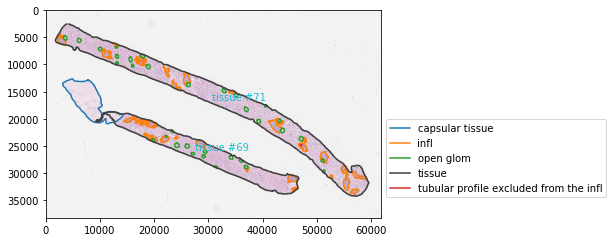

In [7]:
rreader.plot(labels=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

# Inspect ROIs as a `pandas` dataframe

In [8]:
rreader.df.head()

,analyze,area,areamicrons,displayid,id,imagefocus,imagelocation,inputregionid,length,lengthmicrons,name,negativeroa,selected,type,vertices,zoom,polygon
0,1.0,1729228.5,110249.1,1.0,1,-1.0,,0.0,8163.4,2061.3,infl,0.0,0.0,0.0,"[(2303.0, 4610.0), (2303.0, 4614.0), (2303.0, ...",0.277228,"POLYGON ((2303 4610, 2303 4614, 2303 4621, 230..."
1,1.0,406998.5,25948.7,2.0,2,-1.0,,0.0,2475.8,625.1,open glom,0.0,0.0,0.0,"[(3353.0, 4732.0), (3353.0, 4728.0), (3360.0, ...",0.277228,"POLYGON ((3353 4732, 3353 4728, 3360 4718, 337..."
2,1.0,434205.5,27683.3,3.0,3,-1.0,,0.0,2431.2,613.9,open glom,0.0,0.0,0.0,"[(5920.0, 5233.0), (5920.0, 5236.0), (5912.0, ...",0.336634,"POLYGON ((5920 5233, 5920 5236, 5912 5241, 590..."
3,1.0,326631.0,20824.8,4.0,4,-1.0,,0.0,2080.4,525.3,open glom,0.0,0.0,0.0,"[(9888.0, 6888.0), (9880.0, 6897.0), (9877.0, ...",0.336634,"POLYGON ((9888 6888, 9880 6897, 9877 6903, 984..."
4,1.0,1741169.0,111010.4,5.0,5,-1.0,,0.0,9939.7,2509.8,infl,0.0,0.0,0.0,"[(10765.0, 7185.0), (10762.0, 7185.0), (10744....",0.336634,"POLYGON ((10765 7185, 10762 7185, 10744 7197, ..."


## save ROIs as a JSON file

In [9]:
json_filename = rreader.save()
print(json_filename)

/Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.json


In [10]:
df_tissues = rreader.df[rreader.df.name == 'tissue']
df_tissues.polygon

68    POLYGON ((11759.4140625 18717.35015772871, 116...
69    POLYGON ((3859.5 2535.89905362776, 3799.195312...
Name: polygon, dtype: object

## Visualize the shape of a tissue piece

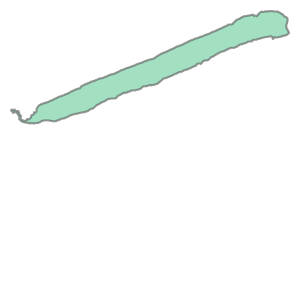

In [11]:
tissue_polygon = df_tissues.polygon.iloc[0]
tissue_polygon

## Sample points within the piece

### Randomly

640


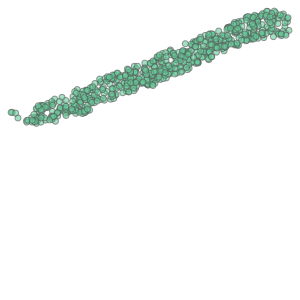

In [12]:
points = slu.sample_points(df_tissues.polygon.iloc[0], n_points=200,  mode='uniform_random', random_seed=42)
print(len(points))
asMultiPoint(points)

### On a grid

199


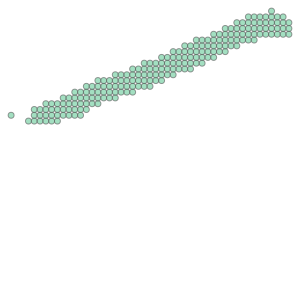

In [13]:
points = slu.sample_points(df_tissues.polygon.iloc[0], n_points=200, mode='grid')
print(len(points))
asMultiPoint(points)

200


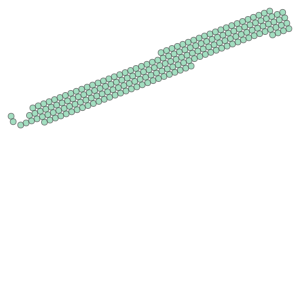

In [14]:
points = slu.sample_points(df_tissues.polygon.iloc[0], n_points=200,  mode='rotated_grid')
print(len(points))
asMultiPoint(points)

## time execution

In [15]:
%%timeit
points = slu.sample_points(df_tissues.vertices.iloc[0], spacing=512, mode='grid')

14.1 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit
points = slu.sample_points(df_tissues.vertices.iloc[0], spacing=512, mode='rotated_grid')

8.24 ms ± 816 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit
points = slu.sample_points(df_tissues.vertices.iloc[0], spacing=512, mode='uniform_random')

8.9 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
contour = np.asarray(df_tissues.vertices.iloc[0])

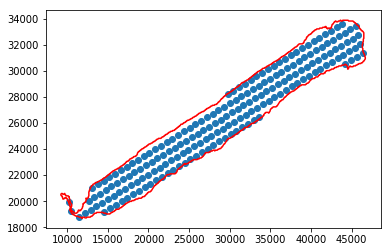

In [21]:
plt.scatter(points[:,0], points[:,1])
plt.plot(contour[:,0], contour[:,1], c='r')

[]

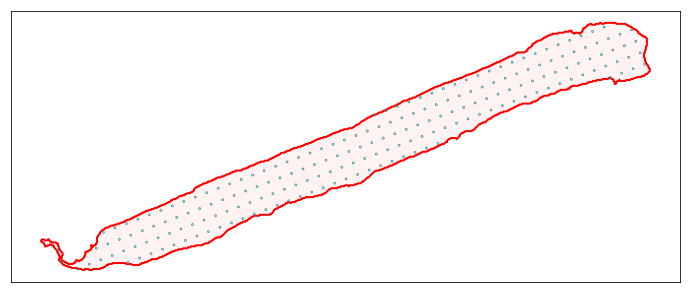

In [24]:
# Visualization using `descartes` and `matplotlib` packages

from shapely.geometry import MultiPoint, Point
import matplotlib.pyplot as plt
from descartes import PolygonPatch

points = MultiPoint([pp for pp in asMultiPoint(points) if isinstance(tissue_polygon & pp, Point)])

fig, ax = plt.subplots(1, figsize=(12,5))

ax.add_patch(PolygonPatch(tissue_polygon, fc=(1,0,0,0.05), ec=(1,0,0,1), lw=2))
ax.add_patch(PolygonPatch(points.buffer(20), fc=(0,1,1,1), ec=(0.2,0.5,0.5,1), lw=2))
ax.relim()
ax.autoscale_view()
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])

## Load and Visualize a patch with a given center point 

(37504.51465390627, 31182.383072308097)

15989.10065939396 19715.718315512262
(256, 256)


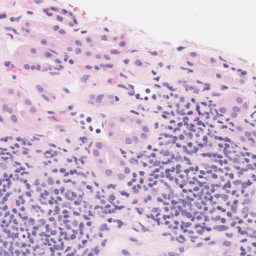

In [35]:
xc, yc, _,_ = points[20].bounds
print(xc, yc)
patch = rreader.get_patch(xc, yc, 1024, target_subsample=4)
print(patch.size)
patch

In [36]:
patch_rois = rreader.get_patch_rois(xc, yc, 1024, target_subsample=4)
print(len(patch_rois))
patch_rois

3


,analyze,area,areamicrons,displayid,id,imagefocus,imagelocation,inputregionid,length,lengthmicrons,name,negativeroa,selected,type,vertices,zoom,polygon
64,1.0,9434.998741,4.602150e+04,65.0,65,-1.0,,0.0,4379.0,1105.7,infl,0.0,0.0,0.0,"[[0.0, 169.04945041485917], [0.0, 256.0], [93....",0.405941,"POLYGON ((0 169.0494504148592, 0 256, 93.54736..."
65,1.0,12216.136338,1.574080e+04,66.0,66,-1.0,,0.0,3082.4,778.3,infl,0.0,0.0,0.0,"[[256.0, 248.3204211219345], [256.0, 218.27902...",0.405941,"POLYGON ((256 248.3204211219345, 256 218.27902..."
68,NaN,58250.143787,7.296906e+06,NaN,69,NaN,NaN,NaN,NaN,NaN,tissue,NaN,NaN,NaN,"[[0.0, 0.0], [0.0, 256.0], [256.0, 256.0], [25...",NaN,"POLYGON ((0 0, 0 256, 256 256, 256 69.03546165..."


infl
infl
tissue


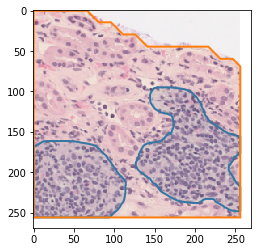

In [37]:
fig,ax, patch, patch_rois = rreader.plot_patch(xc, yc, 1024, target_subsample=4)